=== ANÁLISE RÁPIDA (5% dos dados) ===
=== ANÁLISE SEGURA DE PERFIS DE INVESTIDORAS ===

Usando 5.0% dos dados para análise inicial
Iniciando preprocessamento...
Usando amostra de 5.0% dos dados...
Dataset carregado: 759,287 linhas
Após limpeza: 759,287 linhas (100.0% mantidas)
Usando normalização incremental...
Preprocessamento concluído!

Executando MiniBatch K-means (n_clusters=4)...
Silhouette Score: 0.239
Inertia: 3393948.12

=== ANÁLISE DOS CLUSTERS - MiniBatch K-means ===
Distribuição dos clusters:
  Cluster 0: 180,543 investidoras (23.8%)
  Cluster 1: 281,662 investidoras (37.1%)
  Cluster 2: 249,924 investidoras (32.9%)
  Cluster 3: 47,158 investidoras (6.2%)

--- CLUSTER 0 (180,543 investidoras) ---
Idade: 47.7 ± 13.6 anos (min: 5, max: 124)
Categorias de idade:
  - Adulto: 32.7%
  - Meia_Idade: 20.7%
  - Jovem_Adulto: 17.8%
Estado civil predominante: Desquitado(a) (61.1%)
Top 3 profissões:
  - OUTROS: 35.4%
  - ADMINISTRADOR: 6.1%
  - APOSENTADO (EXCETO FUNCIONÁRIO PÚBLICO): 

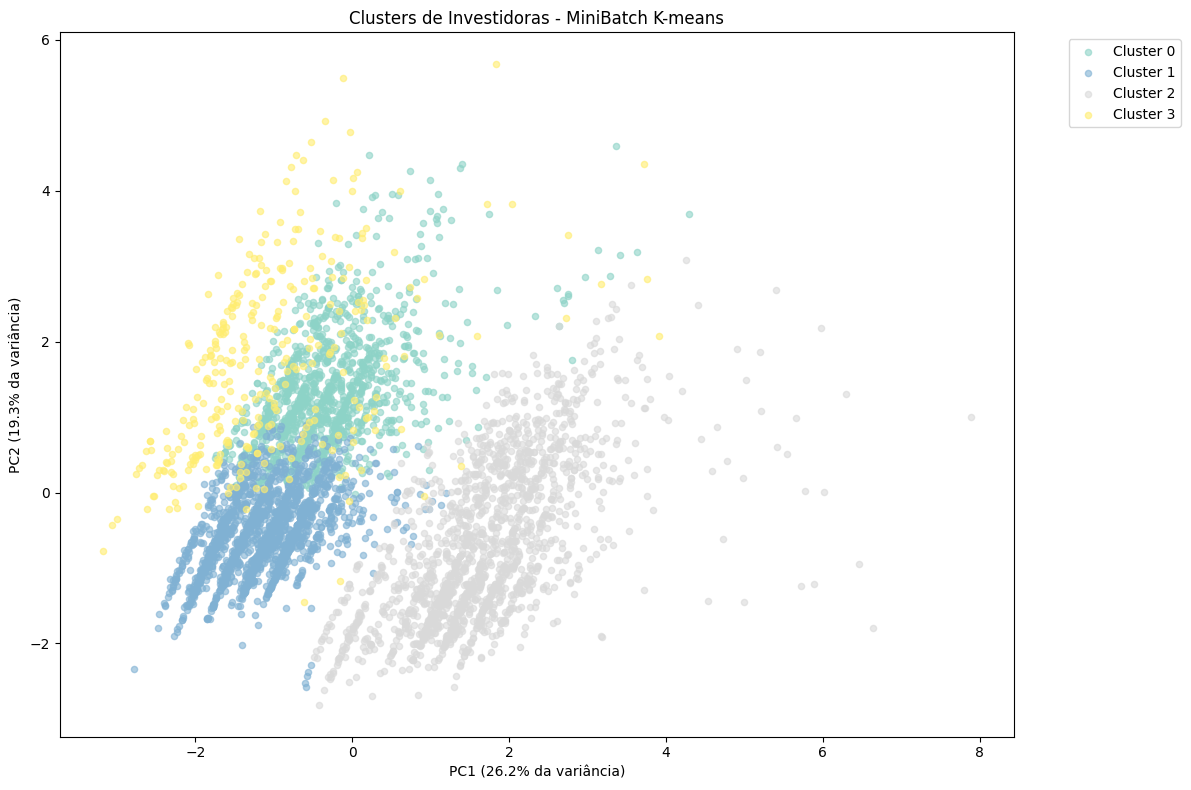

In [ ]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import DBSCAN, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

class InvestorProfiler:
    def __init__(self, parquet_path):
       
        self.ddf = dd.read_parquet(parquet_path)
        self.df_processed = None
        self.clusters = None
        self.scaler = StandardScaler()
        
    def preprocess_data(self, sample_size=None, chunk_size=50000):
     
        print("Iniciando preprocessamento...")
        
        if sample_size and sample_size < 1.0:
            print(f"Usando amostra de {sample_size*100}% dos dados...")
            df = self.ddf.sample(frac=sample_size, random_state=42).compute()
        else:
            print("Carregando dataset completo...")
            df = self.ddf.compute()
        
        print(f"Dataset carregado: {len(df):,} linhas")
        
        initial_size = len(df)
        df = df.dropna(subset=['Idade', 'Profissao', 'Estado Civil', 'UF do Investidor'])
        print(f"Após limpeza: {len(df):,} linhas ({len(df)/initial_size*100:.1f}% mantidas)")
        
        df['Idade_Categoria'] = pd.cut(df['Idade'], 
                                     bins=[0, 25, 35, 45, 55, 65, 100], 
                                     labels=['Jovem', 'Jovem_Adulto', 'Adulto', 
                                            'Meia_Idade', 'Senior', 'Idoso'])
        
        encoders = {}
        categorical_cols = {
            'Estado Civil': 'Estado_Civil_Encoded',
            'Profissao': 'Profissao_Encoded', 
            'UF do Investidor': 'UF_Encoded',
            'Situacao da Conta': 'Situacao_Encoded',
            'Operou 12 Meses': 'Operou_Encoded'
        }
        
        for col, encoded_col in categorical_cols.items():
            le = LabelEncoder()
            df[encoded_col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
        
    
        df['Anos_Desde_Adesao'] = 2024 - df['AnoAdesao']
        
        
        features = ['Idade', 'Estado_Civil_Encoded', 'Profissao_Encoded', 
                   'UF_Encoded', 'Situacao_Encoded', 'Operou_Encoded', 
                   'Anos_Desde_Adesao']
        
      
        self.df_processed = df.copy()
        self.encoders = encoders
        
        X = df[features].values
        
        if len(X) > 100000:
            print("Usando normalização incremental...")
            X_scaled = self._incremental_scaling(X, chunk_size)
        else:
            X_scaled = self.scaler.fit_transform(X)
        
        print("Preprocessamento concluído!")
        return X_scaled, features
    
    def _incremental_scaling(self, X, chunk_size):
       
        n_samples, n_features = X.shape
        
        means = np.zeros(n_features)
        vars = np.zeros(n_features)
        total_samples = 0
        
        for start in range(0, n_samples, chunk_size):
            end = min(start + chunk_size, n_samples)
            chunk = X[start:end]
            
            chunk_mean = np.mean(chunk, axis=0)
            chunk_var = np.var(chunk, axis=0)
            chunk_size_actual = len(chunk)
            
            if total_samples == 0:
                means = chunk_mean
                vars = chunk_var
            else:
                total_samples_new = total_samples + chunk_size_actual
                means = (means * total_samples + chunk_mean * chunk_size_actual) / total_samples_new
                
                vars = (vars * total_samples + chunk_var * chunk_size_actual) / total_samples_new
            
            total_samples += chunk_size_actual
        
        X_scaled = np.zeros_like(X)
        stds = np.sqrt(vars)
        stds[stds == 0] = 1  
        
        for start in range(0, n_samples, chunk_size):
            end = min(start + chunk_size, n_samples)
            X_scaled[start:end] = (X[start:end] - means) / stds
        
        return X_scaled
    
    def cluster_minibatch_kmeans(self, X_scaled, n_clusters=4, batch_size=10000):
        
        print(f"Executando MiniBatch K-means (n_clusters={n_clusters})...")
        
        kmeans = MiniBatchKMeans(n_clusters=n_clusters, 
                               batch_size=batch_size, 
                               random_state=42,
                               n_init=10)
        clusters = kmeans.fit_predict(X_scaled)
        
        if len(X_scaled) > 50000:
            sample_idx = np.random.choice(len(X_scaled), 10000, replace=False)
            silhouette_avg = silhouette_score(X_scaled[sample_idx], clusters[sample_idx])
        else:
            silhouette_avg = silhouette_score(X_scaled, clusters)
        
        print(f'Silhouette Score: {silhouette_avg:.3f}')
        print(f'Inertia: {kmeans.inertia_:.2f}')
        
        return clusters
    
    def cluster_dbscan_sampled(self, X_scaled, sample_size=0.1, eps=0.5, min_samples=30):
      
        print(f"Executando DBSCAN em amostra ({sample_size*100}%)...")
        
        n_samples = len(X_scaled)
        sample_indices = np.random.choice(n_samples, 
                                        int(n_samples * sample_size), 
                                        replace=False)
        X_sample = X_scaled[sample_indices]
        
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        sample_clusters = dbscan.fit_predict(X_sample)
        
        n_clusters = len(set(sample_clusters)) - (1 if -1 in sample_clusters else 0)
        n_noise = list(sample_clusters).count(-1)
        
        print(f'Clusters encontrados na amostra: {n_clusters}')
        print(f'Pontos de ruído na amostra: {n_noise}')
        
        from sklearn.neighbors import NearestNeighbors
        
        non_noise_mask = sample_clusters != -1
        if np.any(non_noise_mask):
            X_clean = X_sample[non_noise_mask]
            clusters_clean = sample_clusters[non_noise_mask]
            
            nn = NearestNeighbors(n_neighbors=5)
            nn.fit(X_clean)
            
            all_clusters = np.full(n_samples, -1)  
            
            batch_size = 10000
            for i in range(0, n_samples, batch_size):
                end_idx = min(i + batch_size, n_samples)
                batch = X_scaled[i:end_idx]
                
                distances, indices = nn.kneighbors(batch)
                
                for j, (dist_row, idx_row) in enumerate(zip(distances, indices)):
                    min_dist = dist_row[0]
                    if min_dist < eps * 2: 
                        all_clusters[i + j] = clusters_clean[idx_row[0]]
            
            return all_clusters
        else:
            return np.full(n_samples, -1)
    

    
    def analyze_clusters(self, clusters, method_name):
        
        self.clusters = clusters
        self.df_processed['Cluster'] = clusters
        
        print(f"\n=== ANÁLISE DOS CLUSTERS - {method_name} ===")
    
        cluster_counts = Counter(clusters)
        print(f"Distribuição dos clusters:")
        for cluster_id, count in sorted(cluster_counts.items()):
            pct = count / len(clusters) * 100
            label = "Ruído" if cluster_id == -1 else f"Cluster {cluster_id}"
            print(f"  {label}: {count:,} investidoras ({pct:.1f}%)")
        
        all_clusters = [c for c in sorted(cluster_counts.keys()) if c != -1]
        
        for cluster_id in all_clusters:
            cluster_data = self.df_processed[self.df_processed['Cluster'] == cluster_id]
            print(f"\n--- CLUSTER {cluster_id} ({len(cluster_data):,} investidoras) ---")
            
           
            idade_stats = cluster_data['Idade'].describe()
            print(f"Idade: {idade_stats['mean']:.1f} ± {idade_stats['std']:.1f} anos "
                  f"(min: {idade_stats['min']:.0f}, max: {idade_stats['max']:.0f})")
          
            idade_dist = cluster_data['Idade_Categoria'].value_counts()
            print(f"Categorias de idade:")
            for cat, count in idade_dist.head(3).items():
                pct = count / len(cluster_data) * 100
                print(f"  - {cat}: {pct:.1f}%")
       
            estado_civil = cluster_data['Estado Civil'].value_counts()
            print(f"Estado civil predominante: {estado_civil.index[0]} ({estado_civil.iloc[0]/len(cluster_data)*100:.1f}%)")
          
            profissoes = cluster_data['Profissao'].value_counts().head(3)
            print(f"Top 3 profissões:")
            for prof, count in profissoes.items():
                pct = count / len(cluster_data) * 100
                print(f"  - {prof}: {pct:.1f}%")
            
        
            ufs = cluster_data['UF do Investidor'].value_counts().head(3)
            print(f"Top 3 UFs:")
            for uf, count in ufs.items():
                pct = count / len(cluster_data) * 100
                print(f"  - {uf}: {pct:.1f}%")
           
            operou_pct = (cluster_data['Operou 12 Meses'] == 'S').mean() * 100
            print(f"Operaram nos últimos 12 meses: {operou_pct:.1f}%")
          
            anos_adesao = cluster_data['Anos_Desde_Adesao'].mean()
            print(f"Tempo médio desde adesão: {anos_adesao:.1f} anos")
    
    def visualize_clusters_efficient(self, X_scaled, clusters, method_name, max_points=5000):
       
        print(f"Gerando visualização dos clusters...")
     
        if len(X_scaled) > max_points:
            sample_idx = np.random.choice(len(X_scaled), max_points, replace=False)
            X_vis = X_scaled[sample_idx]
            clusters_vis = clusters[sample_idx]
        else:
            X_vis = X_scaled
            clusters_vis = clusters
        
        pca = PCA(n_components=2, random_state=42)
        X_pca = pca.fit_transform(X_vis)
        
        plt.figure(figsize=(12, 8))
        
        unique_clusters = sorted(set(clusters_vis))
        colors = plt.cm.Set3(np.linspace(0, 1, len(unique_clusters)))
        
        for i, cluster_id in enumerate(unique_clusters):
            mask = clusters_vis == cluster_id
            label = f'Cluster {cluster_id}' if cluster_id != -1 else 'Ruído'
            alpha = 0.3 if cluster_id == -1 else 0.6
            plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                       c=[colors[i]], label=label, alpha=alpha, s=20)
        
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% da variância)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% da variância)')
        plt.title(f'Clusters de Investidoras - {method_name}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
        return X_pca
    
    def run_safe_analysis(self, sample_size=0.1, methods=['minibatch_kmeans', 'gaussian_mixture']):
      
        print("=== ANÁLISE SEGURA DE PERFIS DE INVESTIDORAS ===\n")
        print(f"Usando {sample_size*100}% dos dados para análise inicial")
        
        X_scaled, features = self.preprocess_data(sample_size=sample_size)
        
        results = {}
        
        if 'minibatch_kmeans' in methods:
            print("\n" + "="*60)
            clusters_kmeans = self.cluster_minibatch_kmeans(X_scaled, n_clusters=4)
            self.analyze_clusters(clusters_kmeans, "MiniBatch K-means")
            self.visualize_clusters_efficient(X_scaled, clusters_kmeans, "MiniBatch K-means")
            results['minibatch_kmeans'] = clusters_kmeans
        
        if 'dbscan' in methods and sample_size <= 0.2:
            print("\n" + "="*60)
            clusters_dbscan = self.cluster_dbscan_sampled(X_scaled, sample_size=0.5)
            self.analyze_clusters(clusters_dbscan, "DBSCAN (Sampled)")
            self.visualize_clusters_efficient(X_scaled, clusters_dbscan, "DBSCAN")
            results['dbscan'] = clusters_dbscan
        
        return results

if __name__ == "__main__":
   
    profiler = InvestorProfiler("tesouro_feminino_filtrado.parquet")
    
    print("=== ANÁLISE RÁPIDA (5% dos dados) ===")
    results_quick = profiler.run_safe_analysis(sample_size=0.05)